In [2]:
# Import libraries
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from bs4 import BeautifulSoup
import pandas as pd
import os

html_tables = {}

input_folder = "./input"

# For every table in the datasets folder...
for table_name in os.listdir(input_folder):
    #this is the path to the file. Don't touch!
    table_path = f'./input/{table_name}'
    
    # Open as a python file in read-only mode
    table_file = open(table_path, 'r')
    
    # Read the contents of the file into 'html'
    html = BeautifulSoup(open(table_path, 'r'))
    
    # Find 'news-table' in the Soup and load it into 'html_table'
    html_table = html.find(id='news-table')
    
    # Add the table to our dictionary
    html_tables[table_name] = html_table   

print('ok!')

ok!


In [3]:
# Read one single day of headlines 
tsla = html_tables['tsla_22sep.html']
# Get all the table rows tagged in HTML with <tr> into 'tesla_tr'
tsla_tr = tsla.findAll('tr')

# For each row...

for i, table_row in enumerate(tsla_tr):
    # Read the text of the element 'a' into 'link_text'
    link_text = table_row.a.get_text()
    # Read the text of the element 'td' into 'data_text'
    data_text = table_row.td.get_text()
    # Print the count
    print(f'{i}:')
    # Print the contents of 'link_text' and 'data_text' 
    print(link_text)
    print(data_text)
    # The following exits the loop after three rows to prevent spamming the notebook, do not touch
    if i == 3:
        break
    

0:
Billionaire investor questions Elon Musk getting 'a pass' after bombshell tweets
Sep-21-18 09:56PM  
1:
Broadcoms Stock Looks Like a Winner
09:30PM  
2:
SHAREHOLDER ALERT:  Pomerantz Law Firm Reminds Shareholders with Losses on their Investment in Tesla, Inc. of Class Action Lawsuit and Upcoming Deadline  TSLA
05:30PM  
3:
Tesla's People Problem and the Inscrutable Musk: 2 Things That Make You Go Hmmm
05:30PM  


In [4]:
# Hold the parsed news into a list
parsed_news = []
# Iterate through the news
for file_name, news_table in html_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        
        # Read the text from the tr tag into text
        text = x.get_text()

        # Split the text in the td tag into a list 
        date_scrape = x.td.text.split()
        headline = x.a.text

        # If the length of 'date_scrape' is 1, load 'time' as the only element
        # If not, load 'date' as the 1st element and 'time' as the second
        
        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        
        # Extract the ticker from the file name, get the string up to the 1st '_'  
        ticker = file_name.split('_')[0]
        
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, headline])

print(parsed_news[:10])

[['tsla', 'Jan-04-19', '08:36PM', 'Why Tesla Stock Popped 6%'], ['tsla', 'Jan-04-19', '07:42PM', "Tesla urges tariff exemption for Chinese-made car computer 'brain'"], ['tsla', 'Jan-04-19', '07:17PM', "Tesla urges tariff exemption for Chinese-made car computer 'brain'"], ['tsla', 'Jan-04-19', '07:07PM', "Tesla urges tariff exemption for Chinese-made car computer 'brain'"], ['tsla', 'Jan-04-19', '06:19PM', 'Elon Musk Isnt Keen on Investors Dragging Girlfriend Into Tweet Lawsuit'], ['tsla', 'Jan-04-19', '06:02PM', 'CNBC Tech Check Evening Edition: January 04, 2019'], ['tsla', 'Jan-04-19', '04:26PM', 'Tesla Ready To Deliver Model 3 Vehicles To China, Europe'], ['tsla', 'Jan-04-19', '04:06PM', 'Stock Market Rally Extends On Fed Chairman Powell, Jobs; Apple, Tesla, Delta Disappoint; Bristol-Myers Buys Celgene: Weekly Review'], ['tsla', 'Jan-04-19', '03:56PM', 'Buy Tesla (TSLA) Stock in 2019 on International Model 3 Expansion?'], ['tsla', 'Jan-04-19', '12:32PM', 'AT&T Stock Still Is One of t

In [10]:
# NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.downloader.download('vader_lexicon')
# New words and values
new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}
# Instantiate the sentiment intensity analyzer with the existing lexicon
vader = SentimentIntensityAnalyzer()
# Update the lexicon
vader.lexicon.update(new_words)

print('ok!')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/horia/nltk_data...


ok!


In [11]:
# Use these column names
columns = ['ticker', 'date', 'time', 'headline']
# Convert the list of lists into a DataFrame
scored_news = pd.DataFrame(parsed_news, columns=columns)

# Iterate through the headlines and get the polarity scores
scores = scored_news['headline'].apply(vader.polarity_scores)

# Convert the list of dicts into a DataFrame
scores_df = pd.DataFrame.from_records(scores)

# Join the DataFrames
scored_news = scored_news.join(scores_df)

# Convert the date column from string to datetime
scored_news['date'] = pd.to_datetime(scored_news.date).dt.date
print(scored_news.head())

  ticker        date     time  \
0   tsla  2019-01-04  08:36PM   
1   tsla  2019-01-04  07:42PM   
2   tsla  2019-01-04  07:17PM   
3   tsla  2019-01-04  07:07PM   
4   tsla  2019-01-04  06:19PM   

                                            headline    neg    neu  pos  \
0                          Why Tesla Stock Popped 6%  0.000  1.000  0.0   
1  Tesla urges tariff exemption for Chinese-made ...  0.000  1.000  0.0   
2  Tesla urges tariff exemption for Chinese-made ...  0.000  1.000  0.0   
3  Tesla urges tariff exemption for Chinese-made ...  0.000  1.000  0.0   
4  Elon Musk Isnt Keen on Investors Dragging Girl...  0.308  0.692  0.0   

   compound  
0    0.0000  
1    0.0000  
2    0.0000  
3    0.0000  
4   -0.4606  


<Axes: xlabel='date'>

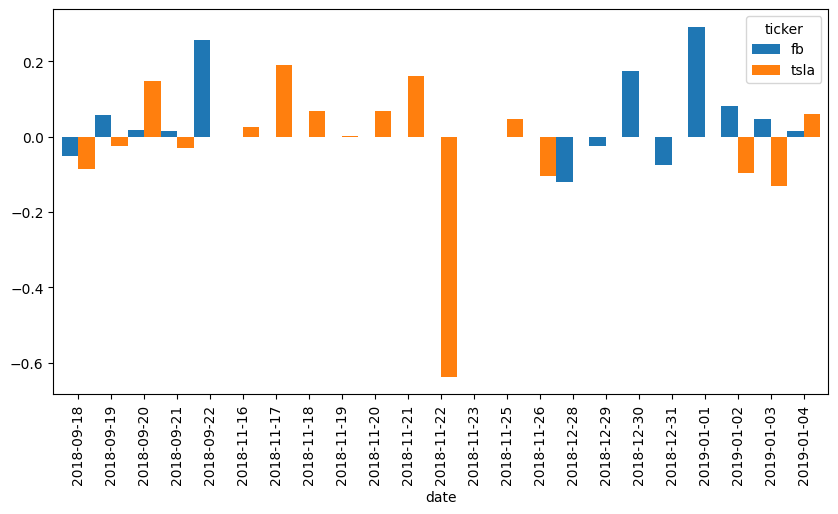

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Group by date and ticker columns from scored_news and calculate the mean
mean_c = scored_news.groupby(['date', 'ticker']).mean()

# Unstack the column ticker
mean_c = mean_c.unstack('ticker')

# Get the cross-section of compound in the 'columns' axis
mean_c = mean_c.xs('compound', axis='columns')
# Plot a bar chart with pandas

mean_c.plot(kind='bar', figsize=(10,5), width=1)

In [27]:
# Count the number of headlines in scored_news (store as integer)
num_news_before = scored_news['headline'].count()

# Drop duplicates based on ticker and headline
scored_news_clean = scored_news.drop_duplicates(subset=['ticker','headline'])
                      
# Count number of headlines after dropping duplicates
num_news_after = scored_news_clean['headline'].count()
                                                        
# Print before and after numbers to get an idea of how we did 
print(f"Before we had {num_news_before} headlines, now we have {num_news_after}")

Before we had 500 headlines, now we have 476


In [54]:
# Set the index to ticker and date
single_day = scored_news_clean.set_index(['ticker', 'date'])

# de aici incepe particular
# Cross-section the fb row
single_day = single_day.xs('fb')

# Select the 3rd of January of 2019
print(single_day.head)
single_day.columns
# single_day['date'] = pd.to_datetime(single_day['date'], format='%Y-%m-%d')
single_day = single_day[0:10]

# Convert the datetime string to just the time
single_day['time'] = pd.to_datetime(single_day['time']).dt.time

# Set the index to time and 
single_day = single_day.set_index('time')

# Sort it
single_day = single_day.sort_index()
print(single_day.info())

<bound method NDFrame.head of                time                                           headline    neg  \
date                                                                            
2018-09-22  11:08AM  How former Facebook and Google engineer Bret T...  0.000   
2018-09-22  12:02AM  White House Drafts Order To Look Into Google, ...  0.000   
2018-09-21  06:21PM  Facebook Withdraws Direct Promotion of Politic...  0.000   
2018-09-21  06:18PM  Facebook's Plan to Pull Back Campaign Support ...  0.000   
2018-09-21  06:10PM                Does F.A.N.G. still stand? 8 trades  0.000   
...             ...                                                ...    ...   
2018-12-28  02:57PM  Accidental Instagram Update of Horizontal Scro...  0.157   
2018-12-28  02:44PM  Zuckerberg Claims Facebook Has 'Fundamentally ...  0.000   
2018-12-28  01:46PM  Facebook CEO Zuckerberg Says Problems Will Tak...  0.231   
2018-12-28  01:30PM  Zuckerberg: Facebook can never fully stop use ...  0.000  

<Axes: xlabel='time'>

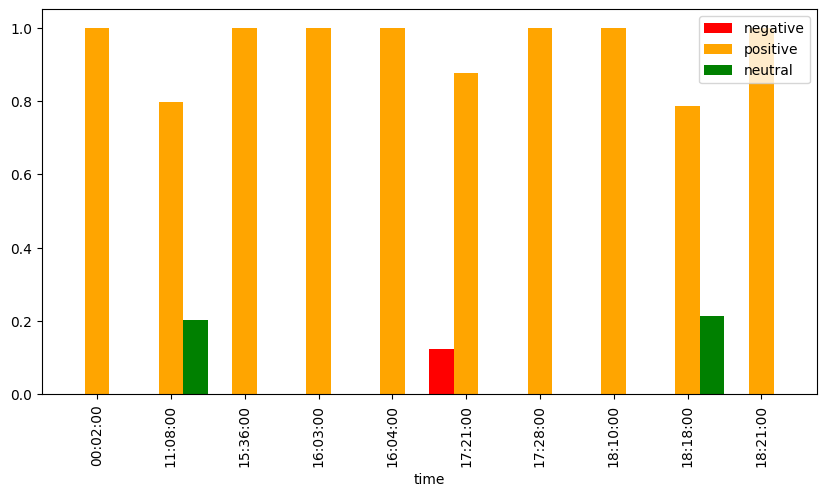

In [55]:
TITLE = "Positive, negative and neutral sentiment for FB on 2019-01-03"
COLORS = ["red", "orange", "green"]

# Drop the columns that aren't useful for the plot
plot_day = single_day.drop(['headline', 'compound'], axis=1)

# Change the column names to 'negative', 'positive', and 'neutral'
plot_day.columns = ['negative', 'positive', 'neutral']

# Plot a stacked bar chart
plot_day.plot(kind='bar', color=COLORS, figsize=(10,5), width=1)
